#MNIST Sim
1. Train an MNIST model (linear only)
2. Cluster the weights
3... Profit

We want to find circuits by including both weight & activation data. 
Lucas' project is mapping from SLT-similar model weights -> compression -> all outputs concatenated. There, you'd cluster by decoder weight.

Here, we're concatentating rows & columns of an MLP (ie key-value framework of MLP) or just a linear model along w/ intermediate activations

Concerns:
1. Any similarity between datapoint activations will be dominated by the zero's. Could partially handle by not including double-zeroes (ie both units don't activate on a datapoint)
2. Unsure how this gets us circuits, especially compared w/ [APD]

Complementary Project: Train an Interp-Bench-esque model where we know what & where the circuits are.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define models
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

class DeepLoRA(nn.Module):
    def __init__(self, lora_rank=4):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, lora_rank)
        self.linear2 = nn.Linear(lora_rank, 10)
        
    def forward(self, x, return_activations=False):
        x = self.flatten(x)
        z = self.linear1(x)
        logits = self.linear2(z)

        if return_activations:
            return logits, z
        else:
            return logits

class MLPModel(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x, return_activations=False):
        x = self.flatten(x)
        pre_acts = self.fc1(x)
        post_acts = self.relu(pre_acts)
        logits = self.fc2(post_acts)
        if return_activations:
            return logits, pre_acts, post_acts
        else:
            return logits

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

batch_size = 256   
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

def train_model(model, epochs=10, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # if batch_idx % 25 == 0:
            #     print(f'Epoch {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
            #           f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        
        # Evaluation
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
        
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Epoch {epoch}: Test accuracy: {accuracy:.2f}%')
    
    return model


# if linear model isn't trained, train it
# import os
# model_path = "models"
# linear_name = "linear_model.pth"
# lora_name = "lora_model.pth"
# mlp_name = "mlp_model.pth"

# device = "cuda" if torch.cuda.is_available() else "cpu"
# if not os.path.exists(os.path.join(model_path, linear_name)):
#     print("Training Linear Model:")
#     linear_model = LinearModel()
#     trained_linear = train_model(linear_model)
#     torch.save(trained_linear.state_dict(), os.path.join(model_path, linear_name))
# else:
#     linear_model = LinearModel()
#     linear_model.load_state_dict(torch.load(os.path.join(model_path, linear_name)))


# if not os.path.exists(os.path.join(model_path, mlp_name)):
#     print("Training MLP Model:")
#     mlp_model = MLPModel()
#     trained_mlp = train_model(mlp_model)
#     torch.save(trained_mlp.state_dict(), os.path.join(model_path, mlp_name))
# else:
#     mlp_model = MLPModel()
#     mlp_model.load_state_dict(torch.load(os.path.join(model_path, mlp_name)))
# linear_model.to(device)
# mlp_model.to(device)

In [2]:
import os
model_path = "models"

# Train LoRA & MLP models of different ranks

batch_size = 256   
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
all_lora_models = []
lora_ranks = [1, 2, 4, 8, 16, 32]
# Also train an MLP model
all_mlp_models = []
for lora_rank in lora_ranks:
    lora_name = f"lora_model_rank_{lora_rank}.pth"
    full_path = os.path.join(model_path, lora_name)

    mlp_name = f"mlp_model_rank_{lora_rank}.pth"
    mlp_full_path = os.path.join(model_path, mlp_name)
    if not os.path.exists(full_path):
        lora_model = DeepLoRA(lora_rank)
        trained_lora = train_model(lora_model, epochs=20)
        torch.save(trained_lora.state_dict(), full_path)
    else:
        print(f"Loading LoRA model from {full_path}")
        lora_model = DeepLoRA(lora_rank)
        lora_model.load_state_dict(torch.load(full_path))

    if not os.path.exists(mlp_full_path):
        print(f"Training MLP model of rank {lora_rank}")
        mlp_model = MLPModel(hidden_size=lora_rank)
        trained_mlp = train_model(mlp_model, epochs=20)
        torch.save(trained_mlp.state_dict(), mlp_full_path)
    else:
        print(f"Loading MLP model from {mlp_full_path}")
        mlp_model = MLPModel(hidden_size=lora_rank)
        mlp_model.load_state_dict(torch.load(mlp_full_path))
    all_lora_models.append(lora_model)
    all_mlp_models.append(mlp_model)

Loading LoRA model from models/lora_model_rank_1.pth
Loading MLP model from models/mlp_model_rank_1.pth
Loading LoRA model from models/lora_model_rank_2.pth
Loading MLP model from models/mlp_model_rank_2.pth
Loading LoRA model from models/lora_model_rank_4.pth
Loading MLP model from models/mlp_model_rank_4.pth
Loading LoRA model from models/lora_model_rank_8.pth
Loading MLP model from models/mlp_model_rank_8.pth
Loading LoRA model from models/lora_model_rank_16.pth
Loading MLP model from models/mlp_model_rank_16.pth
Loading LoRA model from models/lora_model_rank_32.pth
Loading MLP model from models/mlp_model_rank_32.pth


# Weight Similarity

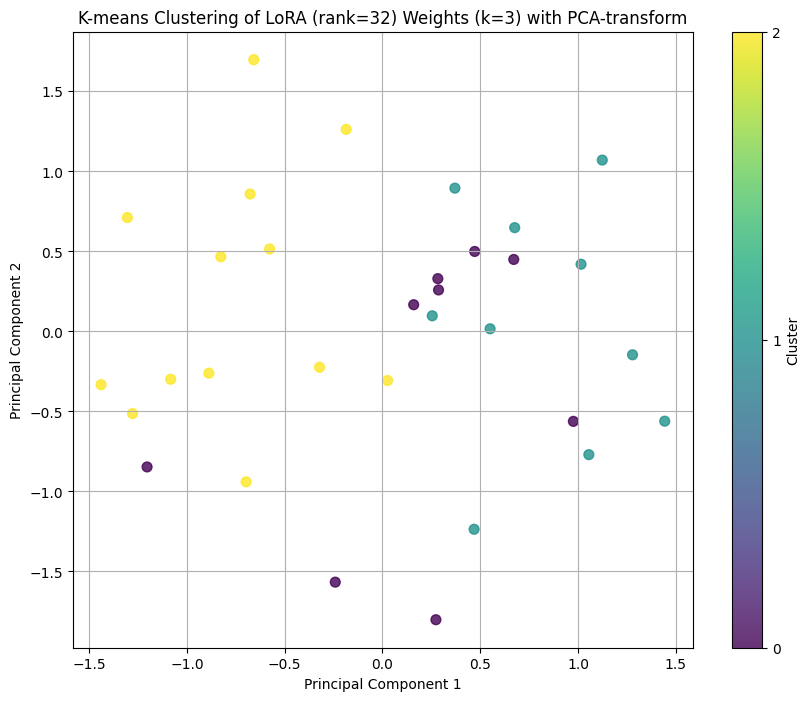

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# For each loRA model, get the weight matrix, concatenate each row-column pair of each hidden dim
lora_model.linear1.weight.data.shape, lora_model.linear2.weight.data.shape
l1 = lora_model.linear1.weight.data # Shape (rank, in_features)
l2 = lora_model.linear2.weight.data # Shape (out_features, rank)

# combine so it's shape (in_features, out_features)
concat_weights = torch.cat([l1, l2.T], dim=1).cpu().numpy() # Shape (rank + out_features, in_features)
concat_weights.shape # (rank, in_features + out_features)

# do k-means clustering
k = 3
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported if you haven't already

# Perform k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(concat_weights)

# Reduce dimensionality to 2D using PCA for plotting
# This step is crucial because your concat_weights likely has many columns (dimensions)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(concat_weights)


# Plot the data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.8)
plt.title(f'K-means Clustering of LoRA (rank={lora_rank}) Weights (k={k}) with PCA-transform')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=range(k), label='Cluster')
plt.grid(True)
plt.show()

In [5]:
from tqdm import tqdm
# Now we want to get the output for each row of the linear model
device = "cuda" if torch.cuda.is_available() else "cpu"
# target_model = all_lora_models[-1].to(device)
target_model = all_mlp_models[-1].to(device)
target_model.eval()
outputs = []
activations_list = []
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        # output, activations = target_model(data, return_activations=True)
        output, _, activations = target_model(data, return_activations=True)
        outputs.append(output)
        activations_list.append(activations)
outputs = torch.cat(outputs)
activations_list = torch.cat(activations_list)


100%|██████████| 40/40 [00:01<00:00, 39.82it/s]


# Most activating inputs
When you look at an image's hidden activations, its:   3.6318,   2.6205, -10.1140, ...
The numbers can be large or small or negative. Importantly, the decoder rows are NOT normed or strictly positive. Meaning it's hard to compare them against each other.

We CAN however compare them to themselves. What's their highest/lowest activations? (If we do a ReLU, then we only need to care about it's highest activations)

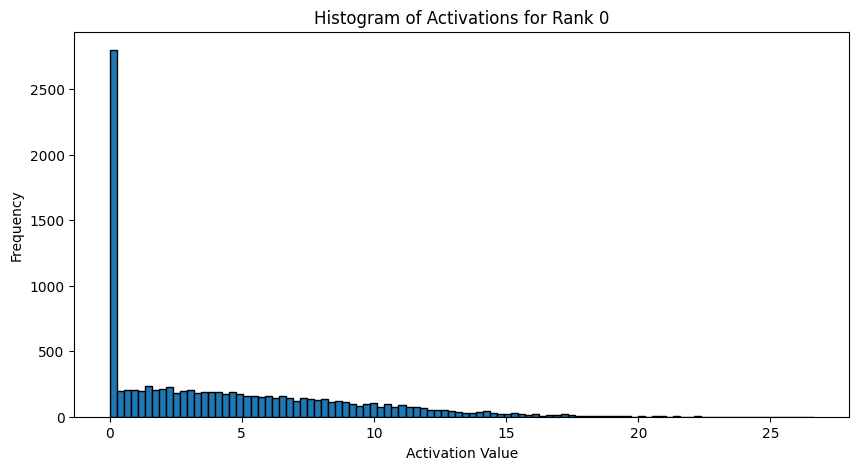

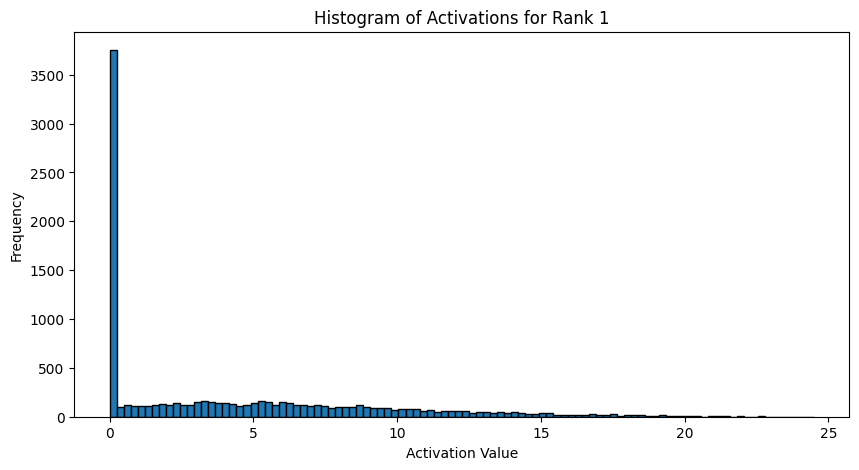

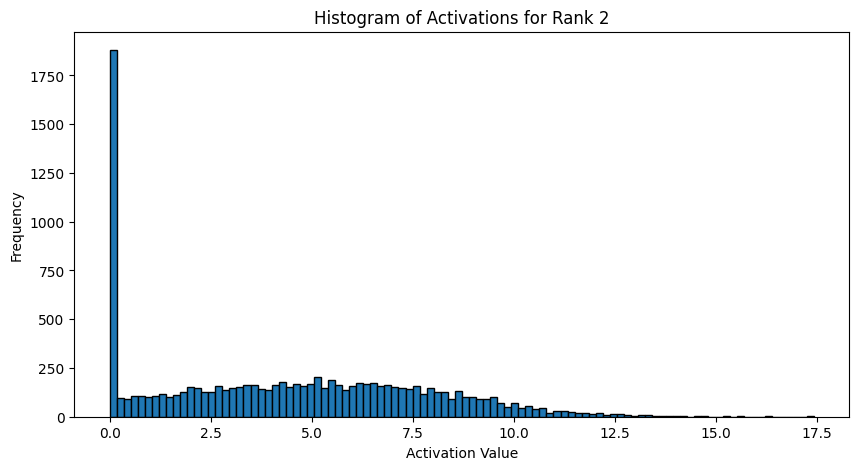

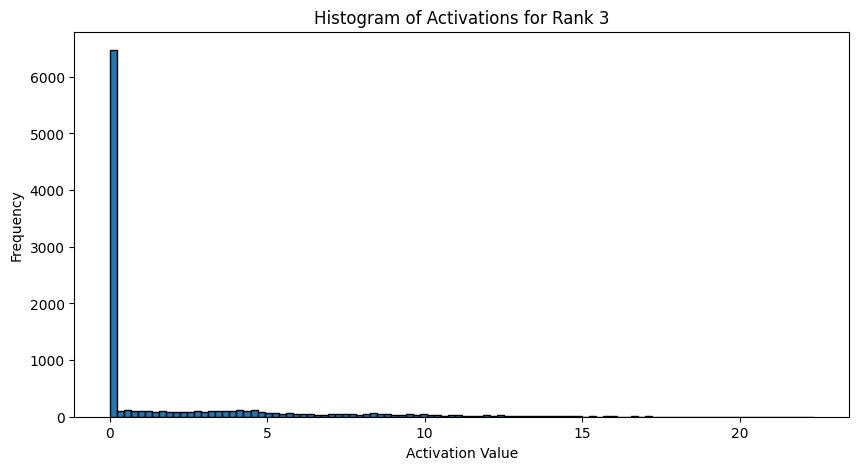

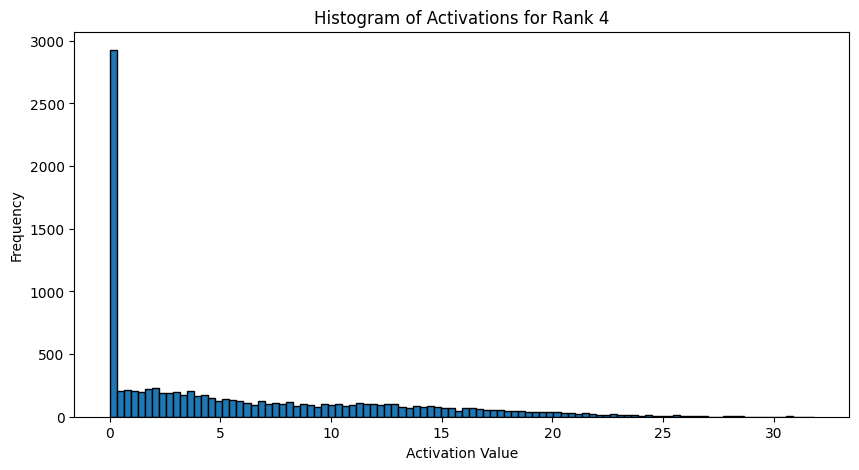

In [6]:
# Plot a histogram of the activations for each rank
for rank_idx in range(5):
    plt.figure(figsize=(10, 5))
    plt.hist(activations_list[:, rank_idx].cpu().numpy(), bins=100, edgecolor='black')
    plt.title(f'Histogram of Activations for Rank {rank_idx}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

In [7]:
# Let's get the top-k index for each rank, pos & neg
top_k = 10
for rank_idx in range(5):
    argsort_idx = torch.argsort(activations_list[:, rank_idx], descending=True)
    pos_idx = argsort_idx[:top_k]
    neg_idx = argsort_idx[-top_k:]
    # Now show the corresponding images

    # test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    # Get the images from the above dataset
    # pos_images = test_dataset[pos_idx]
    # neg_images = test_dataset[neg_idx]
    weight = target_model.linear1.weight.data[rank_idx]
    
    print("Rank Index: ", rank_idx)
    print("Positive:")
    for pos_i in pos_idx:
        plt.imshow(test_dataset[pos_i][0].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.show()
    print("Negative:")
    for neg_i in neg_idx:
        plt.imshow(test_dataset[neg_i][0].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.show()

AttributeError: 'MLPModel' object has no attribute 'linear1'

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def analyze_class_distribution(indices, dataset, top_k_for_stats, num_top_classes_to_show, title):
    """
    Analyzes and prints the class distribution for a given set of indices.

    Args:
        indices (torch.Tensor): Tensor of data indices to analyze.
        dataset: The dataset object (e.g., MNIST test_dataset).
        top_k_for_stats (int): The number of top/bottom samples considered for statistics.
        num_top_classes_to_show (int): How many top classes to display.
        title (str): A descriptive title for the output.
    """
    statistic_labels = [dataset[idx][1] for idx in indices] # Extract labels directly
    label_counts = Counter(statistic_labels)
    total_samples = len(statistic_labels)

    print(f"{title} (Top {top_k_for_stats}):")

    # Get the top N most common classes
    top_classes = label_counts.most_common(num_top_classes_to_show)
    for label, count in top_classes:
        percentage = (count / total_samples) * 100
        print(f"  Class {label}: {percentage:.2f}% ({count} samples)")

    # Add "Others" category if not all classes are shown
    if len(label_counts) > num_top_classes_to_show:
        other_count = total_samples - sum(count for _, count in top_classes)
        other_percentage = (other_count / total_samples) * 100
        print(f"  Others: {other_percentage:.2f}% ({other_count} samples)")


# Assuming you have these defined from your existing setup:
# - activations_list (Tensor of shape [num_samples, num_hidden_units])
# - target_model (your deep linear network)
# - test_dataset (your MNIST test dataset with a transform that converts to Tensor)

# Placeholder for demonstration purposes - replace with your actual data
# For example:
# from torchvision import datasets, transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# test_dataset = datasets.MNIST('./data', train=False, transform=transform)
#
# # Example model (replace with your actual model definition)
# class DeepLinearNet(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = torch.nn.Linear(28*28, 5) # 5 hidden units for example
#         self.linear2 = torch.nn.Linear(5, 10)
#     def forward(self, x):
#         x = x.view(-1, 28*28)
#         h = self.linear1(x)
#         return self.linear2(h)
# target_model = DeepLinearNet()
#
# # Example activations_list (replace with your actual calculated activations)
# # You would typically get this by running your test_dataset through target_model.linear1
# # and storing the output.
# activations_list = torch.randn(len(test_dataset), 5) 

top_k = 3
statistic_topk = 50
num_top_classes_to_show = 3
for rank_idx in range(4):  # Assuming 5 hidden units/ranks
    argsort_idx = torch.argsort(activations_list[:, rank_idx], descending=True)
    pos_idx = argsort_idx[:top_k]
    neg_idx = argsort_idx[-top_k:]

    pos_statistic_idx = argsort_idx[:statistic_topk]
    neg_statistic_idx = argsort_idx[-statistic_topk:]

    print(f"\n--- Rank Index: {rank_idx} ---")

    # Analyze and print statistics for positive activations
    analyze_class_distribution(
        pos_statistic_idx,
        test_dataset,
        statistic_topk,
        num_top_classes_to_show,
        "Positive Activations Class Distribution"
    )

    # Analyze and print statistics for negative activations
    analyze_class_distribution(
        neg_statistic_idx,
        test_dataset,
        statistic_topk,
        num_top_classes_to_show,
        "Negative Activations Class Distribution"
    )
    weight = target_model.linear1.weight.data[rank_idx].detach().to("cpu") # Shape: [1, 784]

    print(f"Rank Index: {rank_idx}")
    print("Positive Activations:")
    for i, data_idx in enumerate(pos_idx):
        image, _ = test_dataset[data_idx]
        image_np = image.cpu().numpy().reshape(28, 28)
        weight_np = weight.cpu().numpy().reshape(28, 28) # Convert weight to NumPy explicitly

        # Calculate the scaled saliency map
        # Element-wise product of the reshaped weight and the input image
        # Ensure weight is also reshaped to 28x28
        saliency_map = (weight_np * image_np)
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # Original Image
        axes[0].imshow(image_np, cmap='gray')
        axes[0].set_title(f'Original Image (Pos {i+1})')
        axes[0].set_xlabel(f'Activation: {activations_list[data_idx, rank_idx]:.2f}')
        axes[0].axis('off')

        # Saliency Map
        # Using a diverging colormap like 'RdBu' or 'seismic' can be good for saliency,
        # where positive values indicate positive contribution and negative indicate negative.
        # You might need to normalize the saliency_map for better visualization,
        # e.g., using vmin and vmax for imshow.
        max_val = np.abs(saliency_map).max()
        axes[1].imshow(saliency_map, cmap='RdBu', vmin=-max_val, vmax=max_val)
        axes[1].set_title(f'Saliency (Rank {rank_idx})')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    print("Negative Activations:")
    for i, data_idx in enumerate(neg_idx):
        image, _ = test_dataset[data_idx]
        image_np = image.cpu().numpy().reshape(28, 28)
        weight_np = weight.cpu().numpy().reshape(28, 28) # Convert weight to NumPy explicitly

        saliency_map = (weight_np * image_np)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(image_np, cmap='gray')
        axes[0].set_title(f'Original Image (Neg {i+1})')
        axes[0].axis('off')

        max_val = np.abs(saliency_map).max()
        axes[1].imshow(saliency_map, cmap='RdBu', vmin=-max_val, vmax=max_val)
        axes[1].set_title(f'Saliency (Rank {rank_idx})')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()


--- Rank Index: 0 ---
Positive Activations Class Distribution (Top 50):
  Class 7: 58.00% (29 samples)
  Class 3: 22.00% (11 samples)
  Class 9: 16.00% (8 samples)
  Others: 4.00% (2 samples)
Negative Activations Class Distribution (Top 50):
  Class 4: 20.00% (10 samples)
  Class 1: 18.00% (9 samples)
  Class 6: 18.00% (9 samples)
  Others: 44.00% (22 samples)


AttributeError: 'MLPModel' object has no attribute 'linear1'


--- Rank Index: 0 ---
Positive Activations Class Distribution (Top 50):
  Class 7: 58.00% (29 samples)
  Class 3: 22.00% (11 samples)
  Class 9: 16.00% (8 samples)
  Others: 4.00% (2 samples)
Negative Activations Class Distribution (Top 50):
  Class 4: 20.00% (10 samples)
  Class 1: 18.00% (9 samples)
  Class 6: 18.00% (9 samples)
  Others: 44.00% (22 samples)
Rank Index: 0
Positive Activations:


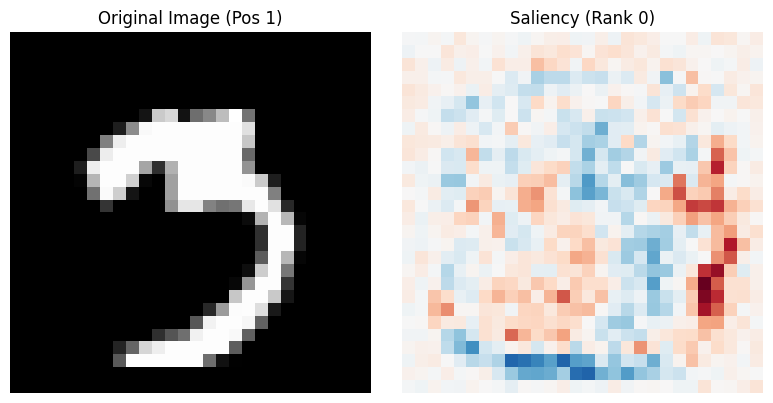

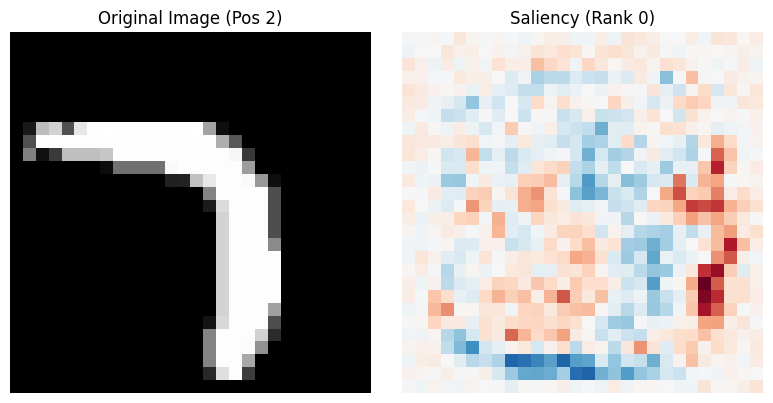

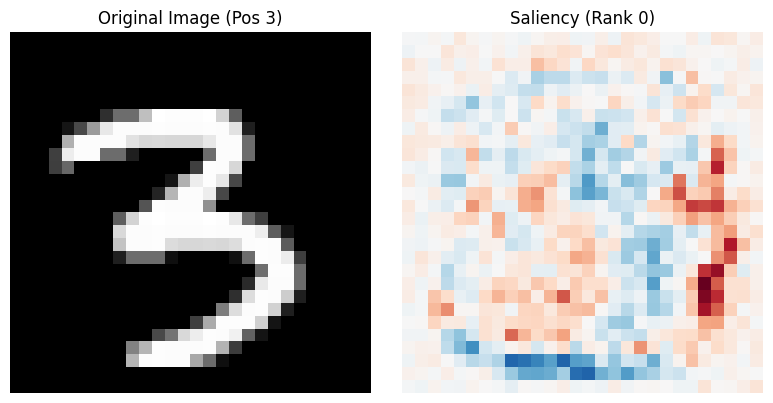

Negative Activations:


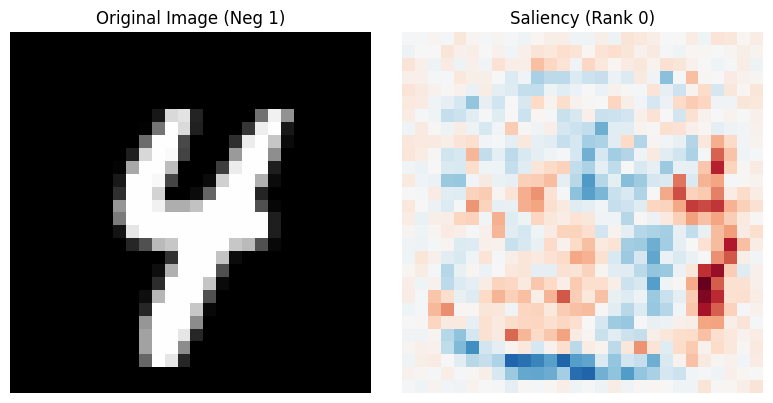

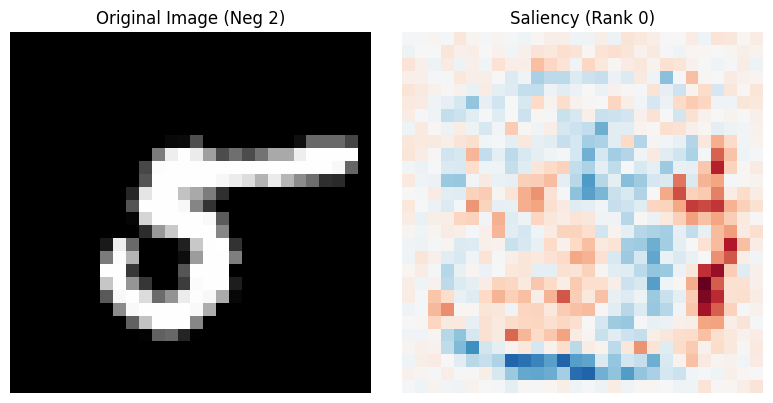

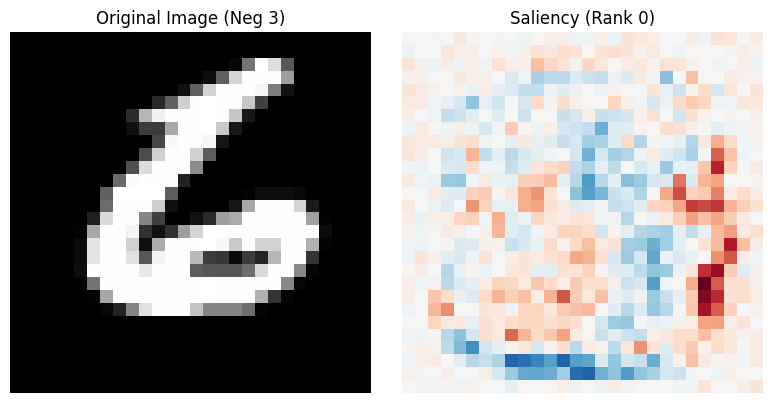


--- Rank Index: 1 ---
Positive Activations Class Distribution (Top 50):
  Class 7: 52.00% (26 samples)
  Class 0: 42.00% (21 samples)
  Class 9: 6.00% (3 samples)
Negative Activations Class Distribution (Top 50):
  Class 1: 28.00% (14 samples)
  Class 8: 16.00% (8 samples)
  Class 2: 12.00% (6 samples)
  Others: 44.00% (22 samples)
Rank Index: 1
Positive Activations:


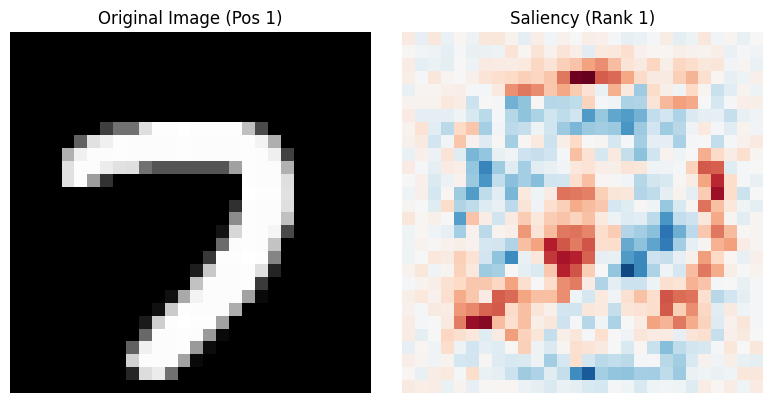

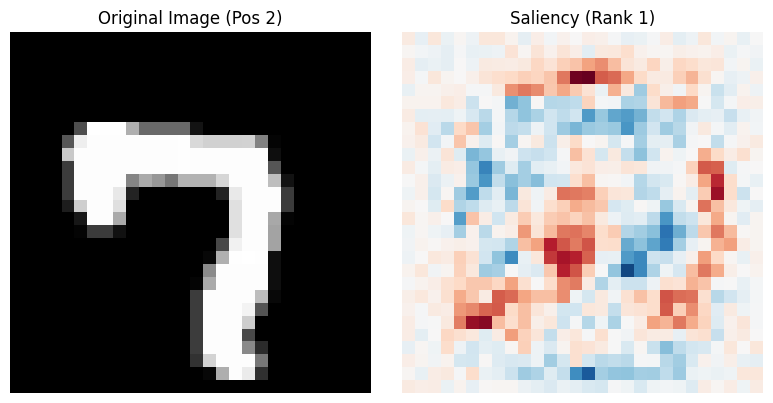

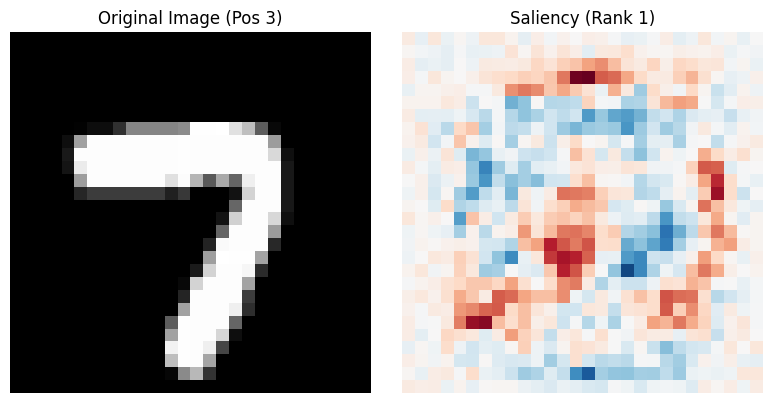

Negative Activations:


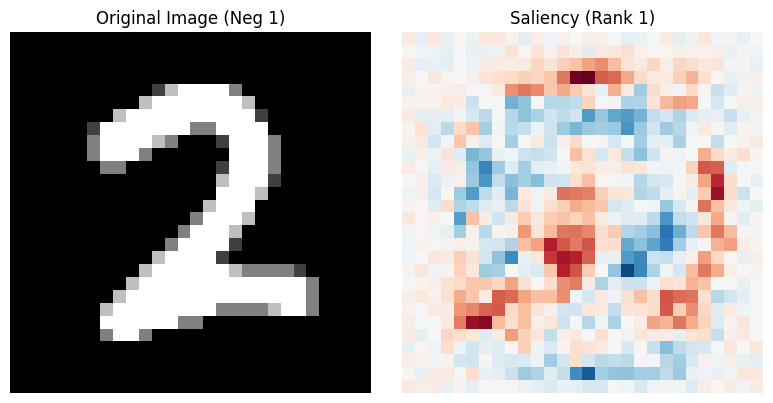

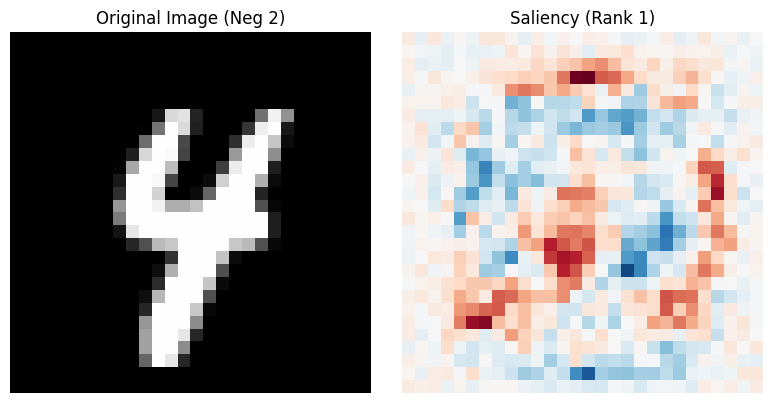

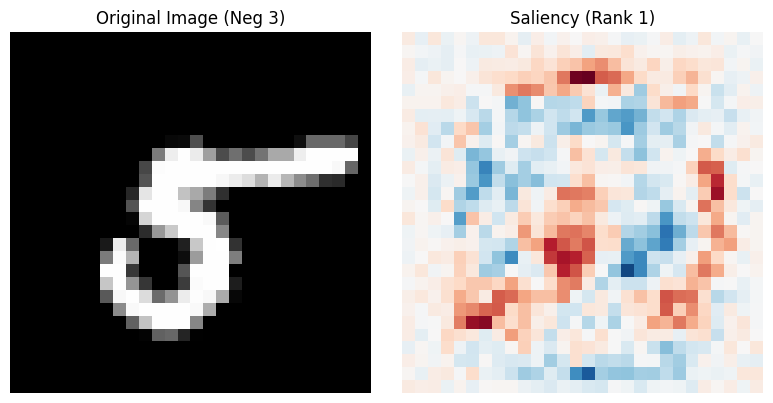


--- Rank Index: 2 ---
Positive Activations Class Distribution (Top 50):
  Class 7: 36.00% (18 samples)
  Class 4: 24.00% (12 samples)
  Class 8: 18.00% (9 samples)
  Others: 22.00% (11 samples)
Negative Activations Class Distribution (Top 50):
  Class 6: 30.00% (15 samples)
  Class 2: 16.00% (8 samples)
  Class 3: 14.00% (7 samples)
  Others: 40.00% (20 samples)
Rank Index: 2
Positive Activations:


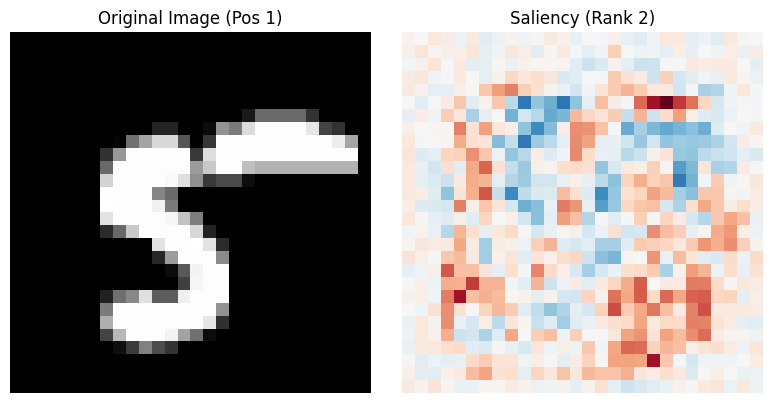

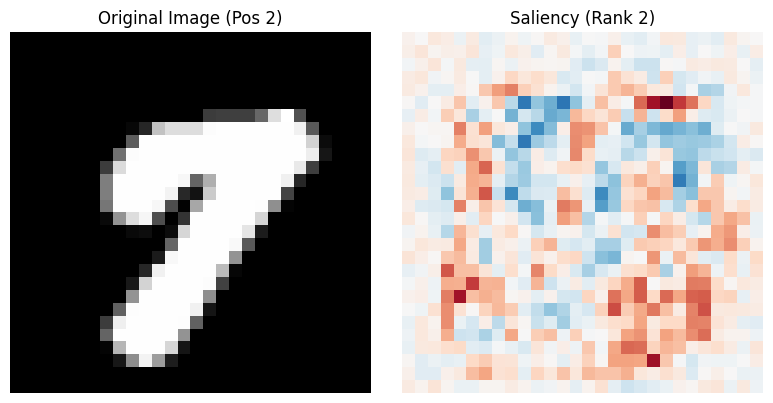

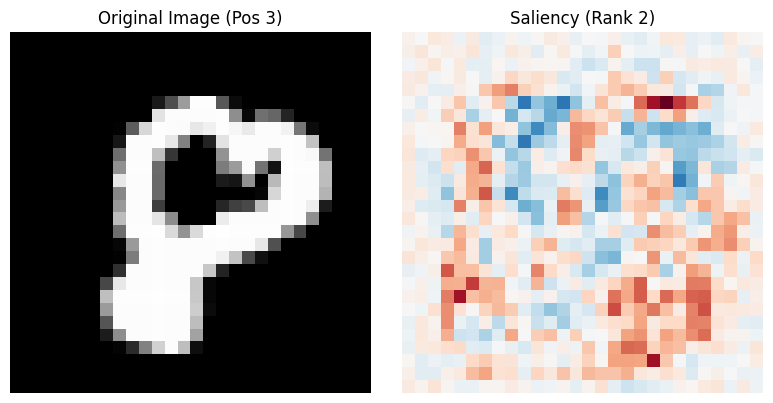

Negative Activations:


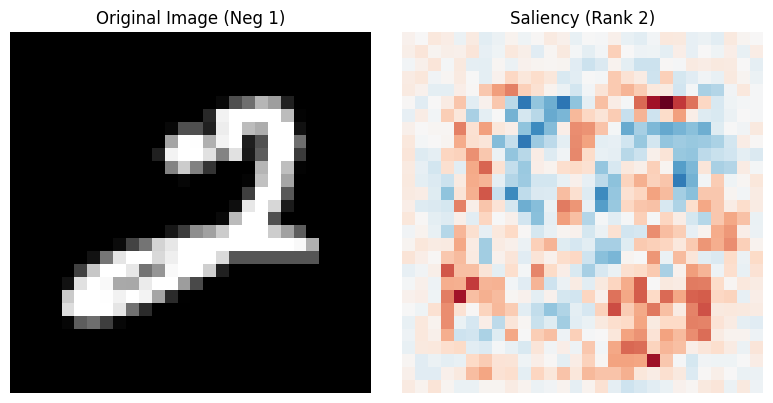

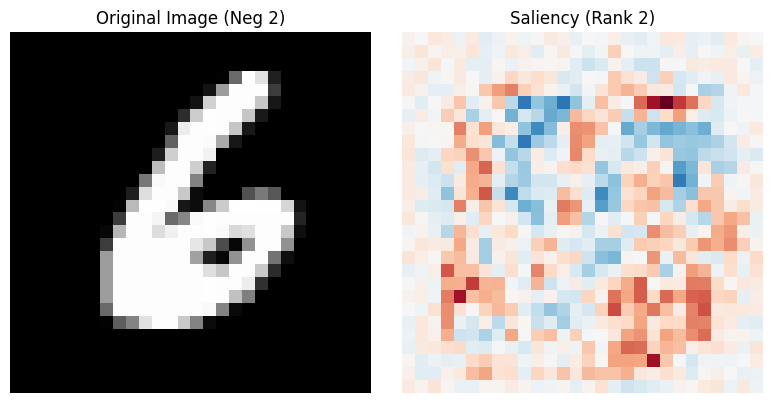

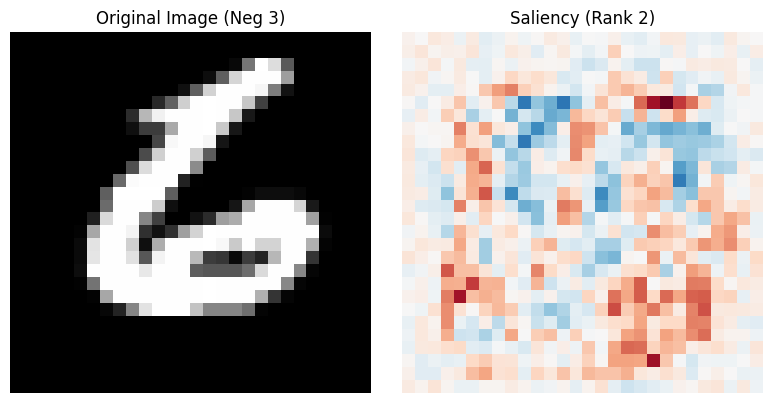


--- Rank Index: 3 ---
Positive Activations Class Distribution (Top 50):
  Class 2: 82.00% (41 samples)
  Class 3: 18.00% (9 samples)
Negative Activations Class Distribution (Top 50):
  Class 4: 18.00% (9 samples)
  Class 0: 18.00% (9 samples)
  Class 6: 18.00% (9 samples)
  Others: 46.00% (23 samples)
Rank Index: 3
Positive Activations:


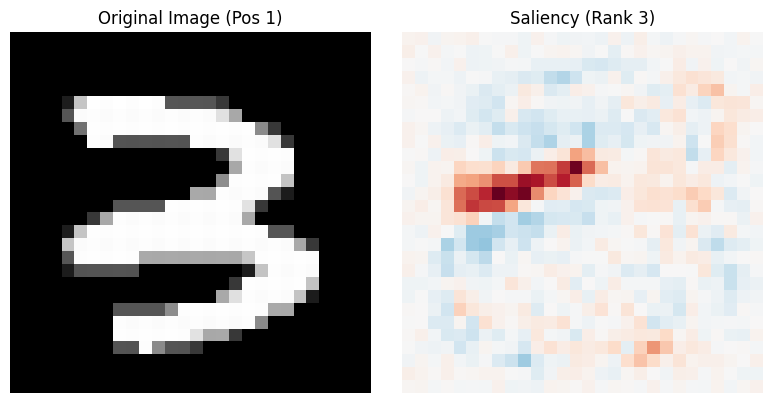

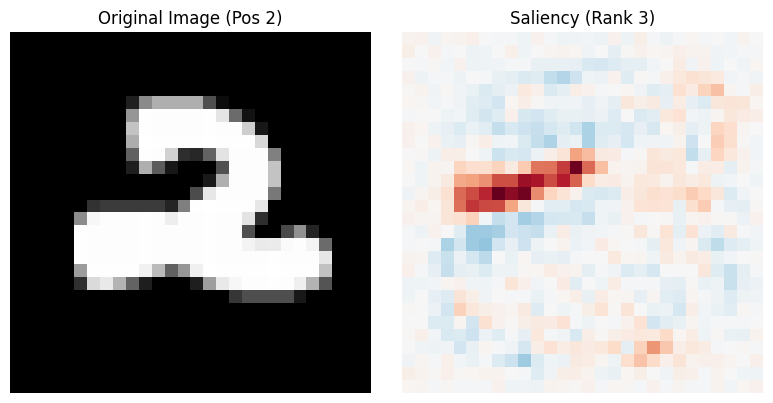

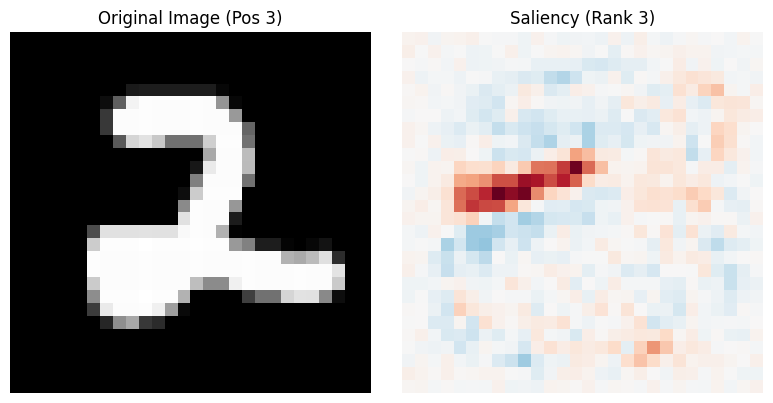

Negative Activations:


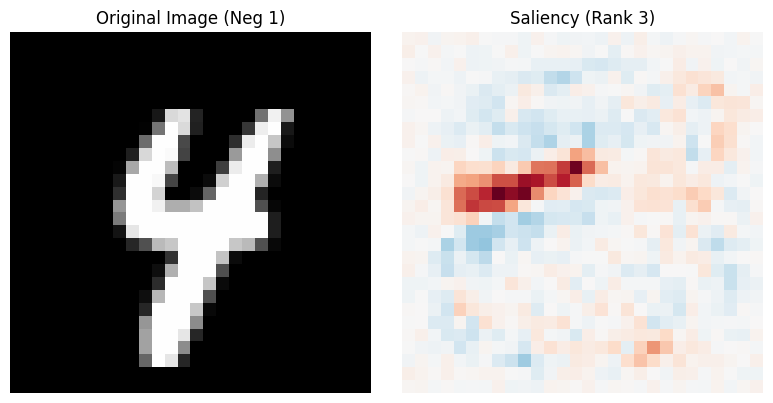

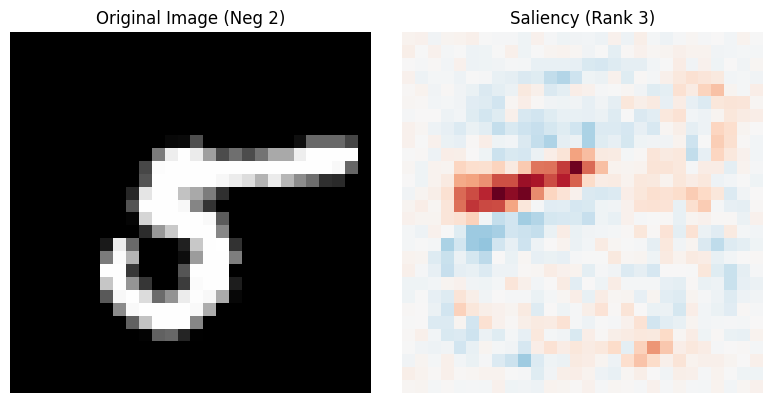

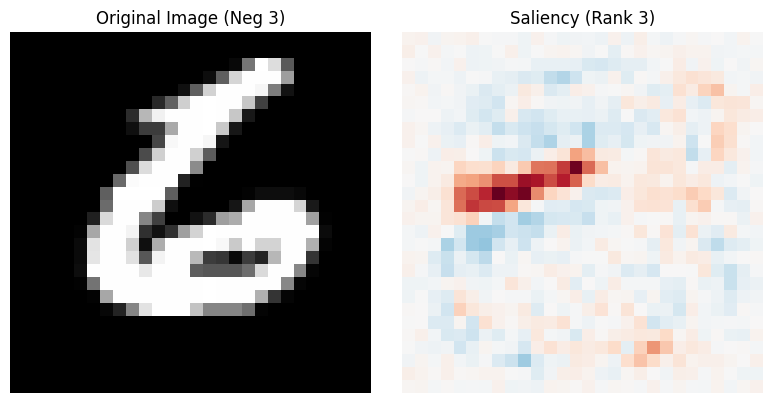

In [10]:
just_weight = True
top_k = 3
statistic_topk = 50
num_top_classes_to_show = 3
for rank_idx in range(4):  # Assuming 5 hidden units/ranks
    argsort_idx = torch.argsort(activations_list[:, rank_idx], descending=True)
    pos_idx = argsort_idx[:top_k]
    neg_idx = argsort_idx[-top_k:]

    pos_statistic_idx = argsort_idx[:statistic_topk]
    neg_statistic_idx = argsort_idx[-statistic_topk:]

    print(f"\n--- Rank Index: {rank_idx} ---")

    # Analyze and print statistics for positive activations
    analyze_class_distribution(
        pos_statistic_idx,
        test_dataset,
        statistic_topk,
        num_top_classes_to_show,
        "Positive Activations Class Distribution"
    )

    # Analyze and print statistics for negative activations
    analyze_class_distribution(
        neg_statistic_idx,
        test_dataset,
        statistic_topk,
        num_top_classes_to_show,
        "Negative Activations Class Distribution"
    )
    # weight = target_model.linear1.weight.data[rank_idx].detach().to("cpu") # Shape: [1, 784]
    weight = target_model.fc1.weight.data[rank_idx].detach().to("cpu") # Shape: [1, 784]

    print(f"Rank Index: {rank_idx}")
    print("Positive Activations:")
    for i, data_idx in enumerate(pos_idx):
        image, _ = test_dataset[data_idx]
        image_np = image.cpu().numpy().reshape(28, 28)
        weight_np = weight.cpu().numpy().reshape(28, 28) # Convert weight to NumPy explicitly

        # Calculate the scaled saliency map
        # Element-wise product of the reshaped weight and the input image
        # Ensure weight is also reshaped to 28x28
        if(just_weight):
            saliency_map = weight_np
        else:
            saliency_map = (weight_np * image_np)
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # Original Image
        axes[0].imshow(image_np, cmap='gray')
        axes[0].set_title(f'Original Image (Pos {i+1})')
        axes[0].set_xlabel(f'Activation: {activations_list[data_idx, rank_idx]:.2f}')
        axes[0].axis('off')

        # Saliency Map
        # Using a diverging colormap like 'RdBu' or 'seismic' can be good for saliency,
        # where positive values indicate positive contribution and negative indicate negative.
        # You might need to normalize the saliency_map for better visualization,
        # e.g., using vmin and vmax for imshow.
        max_val = np.abs(saliency_map).max()
        axes[1].imshow(saliency_map, cmap='RdBu', vmin=-max_val, vmax=max_val)
        axes[1].set_title(f'Saliency (Rank {rank_idx})')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    print("Negative Activations:")
    for i, data_idx in enumerate(neg_idx):
        image, _ = test_dataset[data_idx]
        image_np = image.cpu().numpy().reshape(28, 28)
        weight_np = weight.cpu().numpy().reshape(28, 28) # Convert weight to NumPy explicitly

        if(just_weight):
            saliency_map = weight_np
        else:
            saliency_map = (weight_np * image_np)
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(image_np, cmap='gray')
        axes[0].set_title(f'Original Image (Neg {i+1})')
        axes[0].axis('off')

        max_val = np.abs(saliency_map).max()
        axes[1].imshow(saliency_map, cmap='RdBu', vmin=-max_val, vmax=max_val)
        axes[1].set_title(f'Saliency (Rank {rank_idx})')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
pos_statistic_counts

In [ ]:
# Generate an image where the weights are the saliency map
weight = target_model.linear1.weight.data[rank_idx]

# weight_image
max_val  = test_dataset[neg_i][0].flatten().max()
min_val = test_dataset[neg_i][0].flatten().min()

# Interpololate the weight image to the same range as the max & min val
# ie the mimimum weight image is min_val and the maximum is max_val
weight_image = weight.view(28, 28)
# Scale weight_image to same range as input image
weight_image = (weight_image - weight_image.min()) * (max_val - min_val)/(weight_image.max() - weight_image.min()) + min_val


# Get the saliency map
# weight_image = weight.view(28, 28)
plt.imshow(weight_image.cpu().numpy(), cmap='gray')
plt.show()

In [ ]:
weight_image.min(), weight_image.max()

In [ ]:

# Normalize the saliency map
weight_image = (weight_image - min_val) / (max_val - min_val)
plt.imshow(weight_image.cpu().numpy(), cmap='gray')
plt.show()

In [ ]:
linear_model.linear.weight.data.shape # (10, 784)
# take cos-sim across each row, so it's (10, 10)
cos_sim = torch.nn.functional.cosine_similarity(linear_model.linear.weight.data.unsqueeze(1), linear_model.linear.weight.data, dim=2)

# Plot the cosine similarity matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(cos_sim.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Sim of Linear Weights')
plt.xticks(range(10), range(10))
plt.yticks(range(10), range(10))
plt.xlabel('Class Label')
plt.ylabel('Class Label')
plt.show()

In [ ]:
# Now we want to get the output for each row of the linear model
device = "cuda" if torch.cuda.is_available() else "cpu"
linear_model.eval()
outputs = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = linear_model(data)
        outputs.append(output)
outputs = torch.cat(outputs)


In [ ]:
outputs_normed = outputs / torch.norm(outputs, dim=0, keepdim=True)
cos_sim = outputs_normed.T @ outputs_normed
cos_sim.shape

In [ ]:
cos_sim.min()

In [ ]:
# Plot the cosine similarity matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(cos_sim.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Sim of Outputs')
plt.xticks(range(10), range(10))
plt.yticks(range(10), range(10))
plt.xlabel('Class Label')

In [ ]:
# Cluster the outputs, label them, and plot them
# Get class predictions from outputs
class_preds = torch.argmax(outputs, dim=1)

# Convert outputs to numpy for sklearn
outputs_np = outputs.cpu().numpy()

# Use PCA to reduce to 2D for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
outputs_2d = pca.fit_transform(outputs_np)

# Plot the clusters colored by predicted class
plt.figure(figsize=(10,10))
scatter = plt.scatter(outputs_2d[:,0], outputs_2d[:,1], c=class_preds.cpu(), cmap='tab10')
plt.colorbar(scatter, label='Class Label')
plt.title('PCA of Model Outputs Colored by Predicted Class')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


In [11]:
# import t-SNE
from sklearn.manifold import TSNE

# Use 3D t-SNE
tsne = TSNE(n_components=3, random_state=42)
outputs_tsne = tsne.fit_transform(outputs_np)


In [ ]:
# Use plotly for interactive 3D visualization
import plotly.graph_objects as go

# Create interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=outputs_tsne[:,0],
    y=outputs_tsne[:,1],
    z=outputs_tsne[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=class_preds.cpu().numpy(),
        colorscale='turbo',
        colorbar=dict(title='Class Label')
    )
)])

# Update layout for better visualization
fig.update_layout(
    title='Interactive 3D t-SNE of Model Outputs',
    scene = dict(
        xaxis_title='First t-SNE Component',
        yaxis_title='Second t-SNE Component',
        zaxis_title='Third t-SNE Component'
    )
)

# Show interactive plot
fig.show()

In [ ]:
import numpy as np
# Apply t-SNE to the weight columns

# Get weights from first layer and transpose to get columns
weights = linear_model.linear.weight.data.cpu().numpy().T #(784, 10)

# Apply t-SNE to weight columns
tsne_weights = TSNE(n_components=2, random_state=42)
weights_tsne = tsne_weights.fit_transform(weights)

# just plot the first 2 components
plt.figure(figsize=(10,10))
plt.scatter(weights_tsne[:,0], weights_tsne[:,1], c=np.arange(weights.shape[0]), cmap='turbo')
plt.colorbar(label='Input Feature Index')
plt.title('t-SNE of Input Weight Columns')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.show()

In [ ]:
linear_model.linear.weight.data.shape # (10, 784)